本脚本首先造出一张不同值得多值图片，经过二值化后得到所有值得边缘轮廓，并使用3层vector存储，最终将这3层vector还原为多值图片

In [1]:
#include "JupyterOpencvIncludeLibraries.h"
#include "displayImages.h"
#include <opencv2/opencv.hpp>
#include <vector>
using namespace std;
using namespace cv;

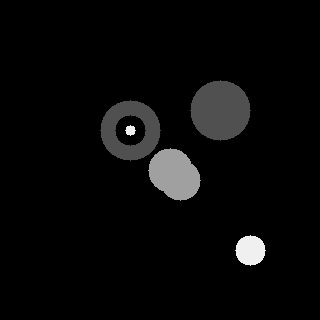

In [2]:
//模拟AI输出数据,0为背景，大于0为缺陷（有多个类别）
int inputH = 320;
int inputW = 320;
cv::Mat test_image(inputH, inputW, CV_8UC1, cv::Scalar(0, 0));
cv::Mat segReturnImage(inputH, inputW, CV_8UC1, cv::Scalar(0, 0));
cv::circle(segReturnImage, cv::Point(150, 150), 80, 0, -1);
cv::circle(segReturnImage, cv::Point(220, 110), 30, 80, -1);
cv::circle(segReturnImage, cv::Point(130, 130), 30, 80, -1);
cv::circle(segReturnImage, cv::Point(130, 130), 15, 0, -1);
cv::circle(segReturnImage, cv::Point(130, 130), 5, 240, -1);
cv::circle(segReturnImage, cv::Point(180, 180), 20, 160, -1);
cv::circle(segReturnImage, cv::Point(170, 170), 22, 160, -1);
cv::circle(segReturnImage, cv::Point(250, 250), 30, 0, -1);
cv::circle(segReturnImage, cv::Point(250, 250), 15, 240, -1);
cv::circle(segReturnImage, cv::Point(50, 250), 15, 0, -1);
displayImage(segReturnImage);

In [3]:
/// <summary>
/// 获取构成ploy的所有树状数据的所有根节点
/// </summary>
/// <param name="hierarchy">ploy的层次结构</param>
/// <param name="allTreeRootNodes">所有树的根节点</param>
/// <returns></returns>
int getTreeRootNodes(vector<cv::Vec4i> hierarchy, vector<int>& allTreeRootNodes) 
{
    for (size_t i = 0; i < hierarchy.size(); i++)
    {
        if (hierarchy[i][3] == -1) 
        {
            allTreeRootNodes.push_back(i);
        }
    }

    return 1;
}

In [4]:
/// <summary>
/// 获取一颗树的某一层所有节点
/// </summary>
/// <param name="hierarchy">ploy的层次结构</param>
/// <param name="curSameLevelNodes">当前层的所有节点</param>
/// <param name="reSameLevelNodes">下一层的所有节点</param>
/// <returns></returns>
int getSameLevelNodes(vector<cv::Vec4i> hierarchy, vector<int>& curSameLevelNodes, vector<int>& nextSameLevelNodes) {
    nextSameLevelNodes.clear();

    for (size_t i = 0; i < curSameLevelNodes.size(); i++)
    {
        int curNode = curSameLevelNodes[i];
        int nextNode = hierarchy[curNode][2];
        if (nextNode > 0) {
            nextSameLevelNodes.push_back(nextNode);
        }
        while (nextNode > 0 and hierarchy[nextNode][0] > 0)
        {
            nextSameLevelNodes.push_back(hierarchy[nextNode][0]);
            nextNode = hierarchy[nextNode][0];

        }
    }

    return 1;
}

In [5]:
/// <summary>
/// 通过ploy的层次结构获得ploy的所有树的分层结构
/// </summary>
/// <param name="hierarchy"></param>
/// <param name="allPloyTree"></param>
/// <returns></returns>
int getAllPloyTree(std::vector<cv::Vec4i> hierarchy, std::vector<std::vector<std::vector<int>>>& allPloyTree) {
    //获取所有树的根节点
    std::vector<int> allTreeRootNodes;
    getTreeRootNodes(hierarchy, allTreeRootNodes);


    for (size_t i = 0; i < allTreeRootNodes.size(); i++) {
        //解析得到一棵树
        std::vector<std::vector<int>> sampleLevelNodes;
        //添加根节点
        std::vector<int> curRootNode{ allTreeRootNodes[i] };
        sampleLevelNodes.push_back(curRootNode);

        //获得每层所有节点
        std::vector<int> reSameLevelNodes;
        getSameLevelNodes(hierarchy, curRootNode, reSameLevelNodes);

        while (reSameLevelNodes.size() > 0) {
            sampleLevelNodes.push_back(reSameLevelNodes);
            getSameLevelNodes(hierarchy, reSameLevelNodes, reSameLevelNodes);
        }
        allPloyTree.push_back(sampleLevelNodes);
    }

    return 1;
}

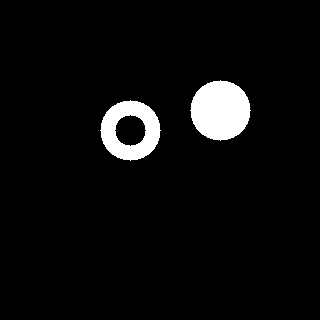

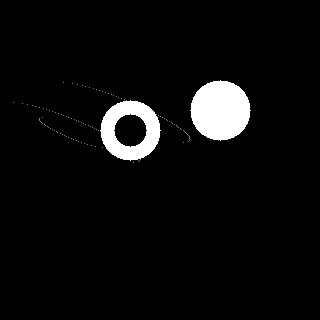

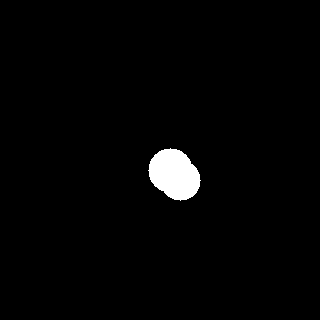

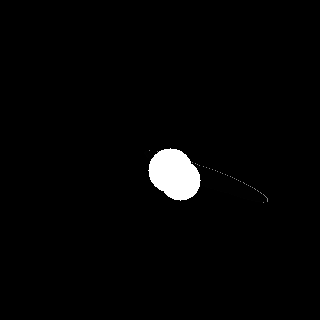

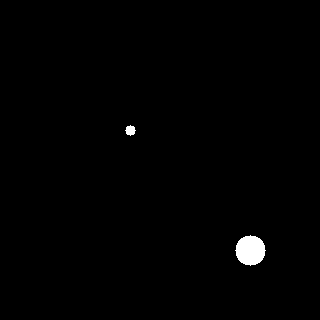

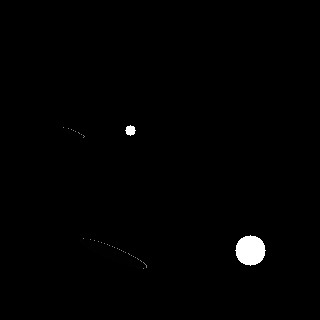

In [6]:
vector<int> labelsValue{80,160,240};//图像上共有3个类别

for (int classValue : labelsValue) {
    //针对类别1进行分析
        //二值化
    cv::Mat classImageBinary(inputH, inputW, CV_8UC1);
    cv::inRange(segReturnImage, cv::Scalar(classValue), cv::Scalar(classValue), classImageBinary);
    //cv::imwrite("classImageBinary.png", classImageBinary);
    displayImage(classImageBinary);

    //求边缘点集合及层次结构
    std::vector<std::vector<cv::Point>> contours;
    std::vector<cv::Vec4i> hierarchy;
    cv::findContours(classImageBinary, contours, hierarchy, cv::RETR_TREE, cv::CHAIN_APPROX_SIMPLE, cv::Point());

    //解析层次结构得到ploy森林
    std::vector<std::vector<std::vector<int>>> allPloyTree;
    getAllPloyTree(hierarchy, allPloyTree);

    //根据ploy森林及边缘点集还原为mask
    bool isInnerMask=true;
    cv::Mat classImageMask(inputH, inputW, CV_8UC1);
    for (int i = 0; i < allPloyTree.size(); i++)
    {
        int fill_value;
        if (isInnerMask) {
            fill_value = 255;
        }
        else
        {
            fill_value = 0;
        }

        for (int j = 0; j < allPloyTree.at(i).size(); j++) {
            for (int k = 0; k < allPloyTree.at(i).at(j).size(); k++) {
                std::vector<std::vector<cv::Point>> curcontours;
                curcontours.push_back(contours[allPloyTree.at(i).at(j).at(k)]);
                cv::drawContours(classImageMask, curcontours, -1, cv::Scalar::all(fill_value), -1);
            }

            if (fill_value == 255) {
                fill_value = 0;
            }
            else
            {
                fill_value = 255;
            }
        }
    }
    string savePath ="classImageMask-" + to_string(classValue) + ".png";
    // cv::imwrite(savePath, classImageMask);
    displayImage(classImageMask);
}